In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

plt.style.use('seaborn-poster')

#filename and folder to plot

folder_example = "/Users/lydia22/Desktop/Junior/amath482 HW2/hw2data/train/"
fname_example  = "walking_1"

vals = np.load(folder_example+fname_example+".npy")
xyz = np.reshape( vals[:,:], (38,3,-1) )

print(xyz.shape)

#define the root joint and scaling of the values
r = 1000
xroot, yroot, zroot = xyz[0,0,0], xyz[0,0,1], xyz[0,0,2]

#define the connections between the joints (skeleton) 
I = np.array(
        [1, 2, 3, 4, 5, 6, 1, 8, 9, 10, 11, 12, 1, 14, 15, 16, 17, 18, 19, 16, 21, 22, 23, 25, 26, 24, 28, 16, 30, 31,
         32, 33, 34, 35, 33, 37]) - 1
J = np.array(
        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32,
         33, 34, 35, 36, 37, 38]) - 1


(38, 3, 100)


In [2]:
# plot the skeleton accroding to joints (each plot is png image in anim folder)
os.makedirs("anim", exist_ok=True)
for tind in range(1,xyz.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    for ijind in range(0,I.shape[0]):
        xline = np.array([xyz[I[ijind],0,tind], xyz[J[ijind],0,tind]])
        yline = np.array([xyz[I[ijind],1,tind], xyz[J[ijind],1,tind]])
        zline = np.array([xyz[I[ijind],2,tind], xyz[J[ijind],2,tind]])
        # use plot if you'd like to plot skeleton with lines
        ax.plot(xline,yline,zline)
    
    # use scatter if you'd like to plot all points without lines 
    # ax.scatter(xyz[:,0,tind],xyz[:,1,tind],xyz[:,2,tind], c = 'r', s = 50)   

    ax.set_xlim([-r+xroot, r+xroot])
    ax.set_zlim([-r+zroot, r+zroot])
    ax.set_ylim([-r+yroot, r+yroot])
    
    plt.savefig('anim/'+f"{tind}.png")
    plt.close()

# when plotting a single sample (the skeleton can simply be plotted without saving an image)
#    plt.draw()
#    plt.pause(.001)
#    plt.show()
    
# save the animated plot as a gif in anim folder 
from PIL import Image

images = [Image.open('anim/'+f"{n}.png") for n in range(1,xyz.shape[2])]
images[0].save('anim/'+fname_example+'.gif', save_all=True, append_images=images[1:], duration=30, loop=0) 

# remove ploted png images
for n in range(1,xyz.shape[2]):
    os.remove('anim/'+f"{n}.png")


In [3]:
#1.1 compile the samples into the matrix 
#1.1.1 make a label list 
from sklearn.decomposition import PCA
movements = ["walking", "jumping", "running"]
folder_train = "/Users/lydia22/Desktop/Junior/amath482 HW2/hw2data/train/"
#1.1.2 make a empty list
X_list = []
#1.1.3 make a nested loop, include each movement from 1 to 5
for move in movements:
    for i in range(1,6):
        fname = f"{move}_{i}.npy"
        full_path = os.path.join(folder_train, fname)
        #Placed them in the correct directory
        data  = np.load(full_path) 
        #load these npy files as numpy array 
        X_list.append(data)
X_train = np.hstack(X_list) #give shape for a list 
print("X_train shape:", X_train.shape)

X_train shape: (114, 1500)


In [4]:
#1.2 perform PCA
pca = PCA() #reduce the dimension (built-in)
pca.fit(X_train.T) #first transform the x data, second fit the x data 
# we use transform because xk = Uk^Tx, Uk is the projection matrix, xk is the tranformed data
#find the singular values 
singular_val = pca.singular_values_ #PCA functions to extract the singular vals
#cumulative energy = (sum k i=1 lambdai/ sum d j=1 lambdaj) = cumulative sum of eigenvals
exp_var  = pca.explained_variance_ratio_
cumulative_energy = np.cumsum(exp_var)
#reference: PCA Explained Variance Concepts with Python Example
#1.3 investigate spatial modes
thresholds = [0.7, 0.8, 0.9, 0.95] 
# approximate 𝑋𝑡𝑟𝑎𝑖𝑛 up to 70%, 80% , 90% , 95% in Frobenius norm
modes = []
for i in thresholds: 
    mode = np.searchsorted(cumulative_energy,i)+1
    #np.searchsorted: find the indices to help maintain the order
    # in this case, we are finding smallest number of principal components (modes) 
    #needed to reach a specific cumulative energy threshold 
    modes.append(mode)
    print(f"To capture {int(i * 100)}% of the total energy, we need {mode} modes.")

To capture 70% of the total energy, we need 2 modes.
To capture 80% of the total energy, we need 3 modes.
To capture 90% of the total energy, we need 5 modes.
To capture 95% of the total energy, we need 7 modes.


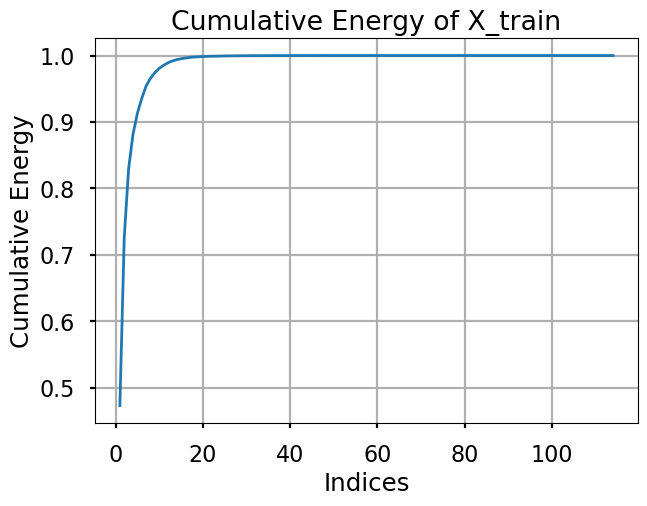

In [5]:
# 1.4 Plot cumulative energy
plt.figure(figsize=(7,5))
plt.plot(range(1, len(cumulative_energy)+1), cumulative_energy, '-', linewidth=2)
plt.xlabel('Indices')
plt.ylabel('Cumulative Energy')
plt.title('Cumulative Energy of X_train')
plt.grid(True)

In [6]:
# 2.1 truncate modes set to 2 and 3 modes 
# truncating to 2D & 3D
def truncate_data(X,pca, n_components):
    return pca.transform(X.T)[:, :n_components]

X_2D = truncate_data(X_train, pca, 2)  # shape (1500, 2)
X_3D = truncate_data(X_train, pca, 3)  # shape (1500, 3)
# X pca = pca.transform(xtrainT)
# X pca,2 = Xpca[:,:2] col 0 and 1 same thing with pca,3


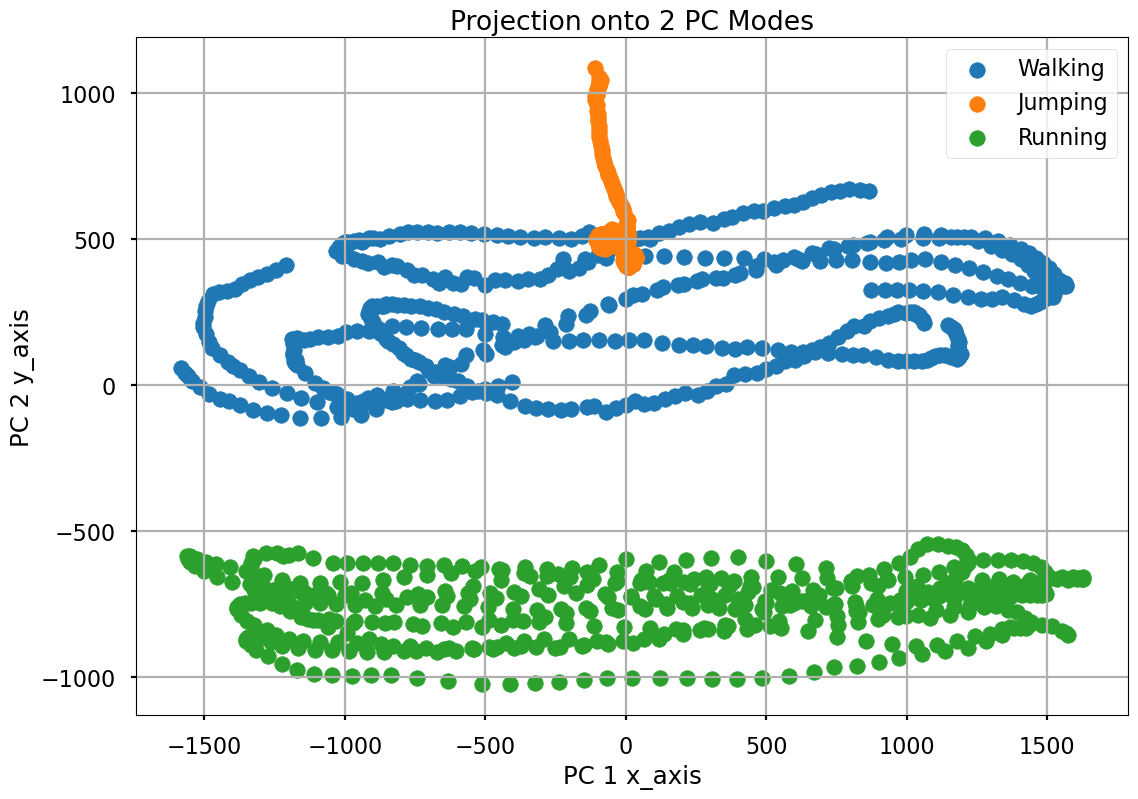

In [7]:
#2.2 colormaping 
# because we put 15 movements into the same file, now we have 15*100 columns in total. 
# define the range for each movement 
# walking is 0 - 499, jumping is 500-999, running is 1000-1500

walking_indices = slice(0, 500)
jumping_indices = slice(500, 1000)
running_indices = slice(1000, 1500)  

#extract the data for each movement 
walking = X_2D[walking_indices]
jumping = X_2D[jumping_indices]
running = X_2D[running_indices]
walking3= X_3D[walking_indices]
jumping3= X_3D[jumping_indices]
running3= X_3D[running_indices]
# plot 2D
plt.scatter(walking[:,0], walking[:,1], label='Walking')
plt.scatter(jumping[:,0], jumping[:,1], label='Jumping')
plt.scatter(running[:,0], running[:,1], label='Running')
plt.legend()
plt.xlabel('PC 1 x_axis')
plt.ylabel('PC 2 y_axis')
plt.title('Projection onto 2 PC Modes')
plt.grid(True)
plt.show()

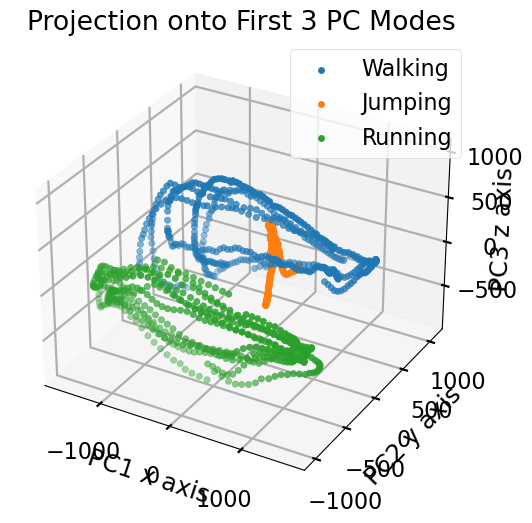

In [8]:
# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(walking3[:,0], walking3[:,1], walking3[:,2], label='Walking')
ax.scatter(jumping3[:,0], jumping3[:,1], jumping3[:,2], label='Jumping')
ax.scatter(running3[:,0], running3[:,1], running3[:,2], label='Running')
ax.set_xlabel('PC1 x axis')
ax.set_ylabel('PC2 y axis')
ax.set_zlabel('PC3 z axis')
ax.set_title('Projection onto First 3 PC Modes')
ax.legend()
plt.show()

In [9]:
from sklearn.metrics import accuracy_score
# we want to assign labels for each movement 
# row 0 = label 0 =  walking; 1 for jumping; 2 for running
ground_truth_labels = np.array([0] * 500 + [1] * 500 + [2] * 500)

# similar thing for truncated function
X_train_pca = pca.transform(X_train.T)   # each row is a column from X_train

k_values = [1, 5, 7, 10, 20, 50]
train_accuracies = []

#4 define a classification for labeling 
def classification(sample_k, centroids):
    """ 
    Parameters:
    - sample_k: A data point in PCA space (1 sample)
    - centroids: Array of centroids 
    Returns:
    - The index of the closest centroid (0 = walking, 1 = jumping, 2 = running)
    """
    distances = np.linalg.norm(centroids - sample_k, axis=1)
    return np.argmin(distances)

for k in k_values:
    X_train_k = X_train_pca[:, :k] # Truncate to the first k principal components

    walking_k  = X_train_k[0:500, :]     # shape (500, k)
    jumping_k  = X_train_k[500:1000, :]  # shape (500, k)
    running_k  = X_train_k[1000:1500, :] # shape (500, k)

    walking_centroid  = walking_k.mean(axis=0)  # shape (k,)
    jumping_centroid  = jumping_k.mean(axis=0)  # shape (k,)
    running_centroid  = running_k.mean(axis=0)  # shape (k,)

    # add them into the same vector: 
    centroids_k = np.vstack([walking_centroid, jumping_centroid, running_centroid])

    predicted_labels = []
    # writing a for loop to make that each data are labled based on their distance to centroid
    for i in range(1500):
        data = X_train_k[i, :]  
        label = classification(data, centroids_k)
        predicted_labels.append(label) #add the label values to the list 
    # Convert to NumPy array
    predicted_labels = np.array(predicted_labels)  

    # Compute accuracy
    train_accuracy = accuracy_score(ground_truth_labels, predicted_labels)
    train_accuracies.append(train_accuracy)

    print(f"k = {k}, Training Accuracy: {train_accuracy * 100:.2f}%")

k = 1, Training Accuracy: 50.73%
k = 5, Training Accuracy: 75.07%
k = 7, Training Accuracy: 87.07%
k = 10, Training Accuracy: 88.80%
k = 20, Training Accuracy: 91.07%
k = 50, Training Accuracy: 91.07%


1. Selecting all rows, but columns for specific movement 
2. computing the centroid (mean across time)
3. storing the centroid in a singal array 
4. creating the ground truth lables for one array 
5. defining the classification function, using np.linalg.norm to compute Euclidean distance
6. extracting a single column and classify each column with labels
7. computing the accuracy 

In [10]:
#5. test data 
# load the test data 
folder_test = "/Users/lydia22/Desktop/Junior/amath482 HW2/hw2data/test/"
Xtest_list = []
movements = ["walking", "jumping", "running"]
for move in movements:
    fname = f"{move}_1t.npy"
    test_path = os.path.join(folder_test, fname)
    #Placed them in the correct directory
    tdata  = np.load(test_path) 
    #load these npy files as numpy array 
    Xtest_list.append(tdata)
X_test = np.hstack(Xtest_list) #give shape for a list

In [11]:

test_ground_truth_labels = np.array([0]*100 + [1]*100 + [2]*100) 
test_accuracies = []
X_test_pca = pca.transform(X_test.T) 

for k in k_values:
    X_test_k = X_test_pca[:, :k] # Truncate to the first k principal components

    walking_t  = X_test_k[0:100, :]    
    jumping_t  = X_test_k[100:200, :]  
    running_t  = X_test_k[200:300, :]

    walking_tcentroid  = walking_t.mean(axis=0)  
    jumping_tcentroid  = jumping_t.mean(axis=0)  
    running_tcentroid  = running_t.mean(axis=0)  

    # add them into the same vector: 
    centroids_k = np.vstack([walking_tcentroid, jumping_tcentroid, running_tcentroid])
    test_labels = []
    # writing a for loop to make that each data are labled based on their distance to centroid
    for i in range(300):
        data = X_test_k[i, :]  
        label = classification(data, centroids_k)
        test_labels.append(label) 
    
    # Convert to NumPy array
    test_labels = np.array(test_labels)  

    # Compute accuracy
    test_accuracy = accuracy_score(test_ground_truth_labels, test_labels)
    test_accuracies.append(test_accuracy)

    print(f"k = {k}, Training Accuracy: {test_accuracy * 100:.2f}%")

k = 1, Training Accuracy: 51.00%
k = 5, Training Accuracy: 97.33%
k = 7, Training Accuracy: 100.00%
k = 10, Training Accuracy: 100.00%
k = 20, Training Accuracy: 100.00%
k = 50, Training Accuracy: 100.00%


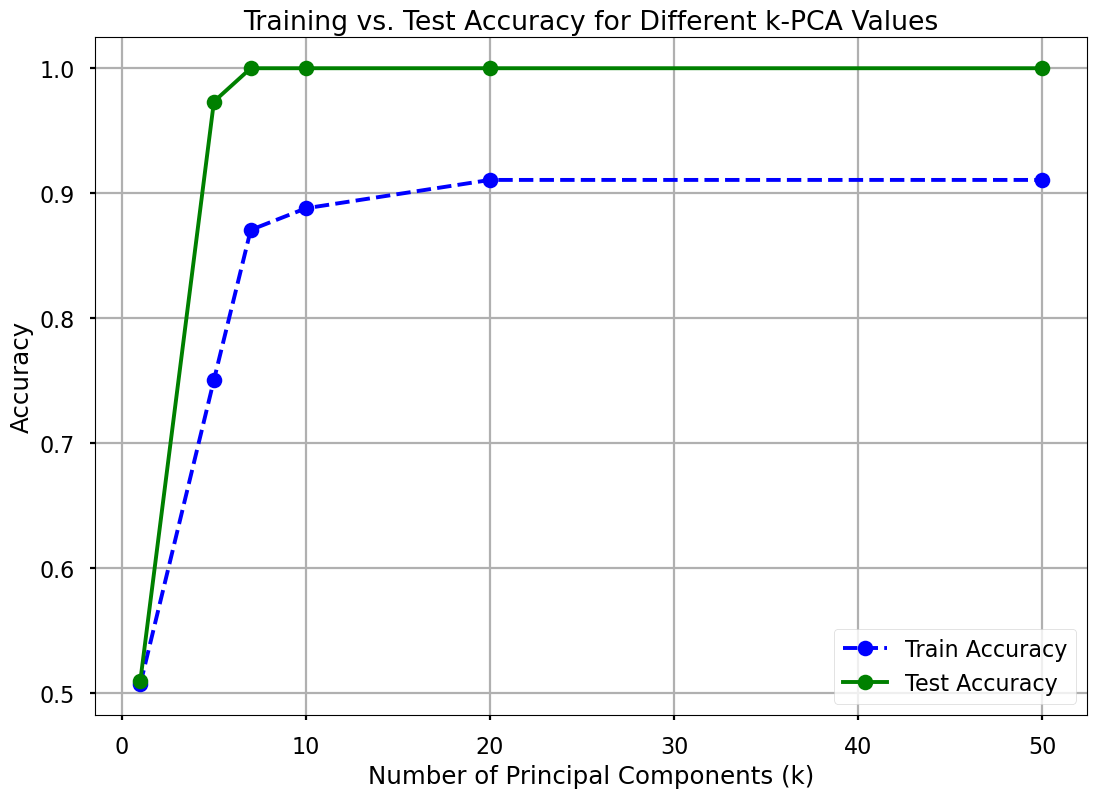

In [12]:
plt.plot(k_values, train_accuracies, 'o', linestyle='--', color='b', label="Train Accuracy")
plt.plot(k_values, test_accuracies, 'o', linestyle='-', color='g', label="Test Accuracy")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Accuracy")
plt.title("Training vs. Test Accuracy for Different k-PCA Values")
plt.legend()
plt.grid()
plt.show()